In [1]:
import h5py, os, glob
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from imp import reload

from noise_correlations.data import datasets
from noise_correlations import discriminability, null_models
from noise_correlations.discriminability import lfi_data, lda_data, corrected_lfi_data, mv_normal_jeffreys_data
from noise_correlations.null_models import random_rotation_data, shuffle_data
from noise_correlations import plot

In [11]:
# data paths
fname = 'nc_datasets/R32_B7_HG_ext_rsp.h5'
with h5py.File(fname, 'r') as f:
    resp = f['final_rsp'][:]
n_el, n_samples, n_freq, n_attn = resp.shape
Yp = np.transpose(resp[..., 5], axes=(0, 2, 1))
trial_medians = np.median(Yp, axis=-1)
keep = (trial_medians.max(axis=1) - trial_medians.min(axis=1)) >= 3.
Yp = Yp[keep]
bfs = np.median(Yp, axis=-1).argmax(axis=1)
idxs = np.argsort(bfs)
bfs = bfs[idxs]
Yp = Yp[idxs]
n_el, n_freq, n_samples = Yp.shape

In [12]:
Yp.shape

(43, 30, 20)

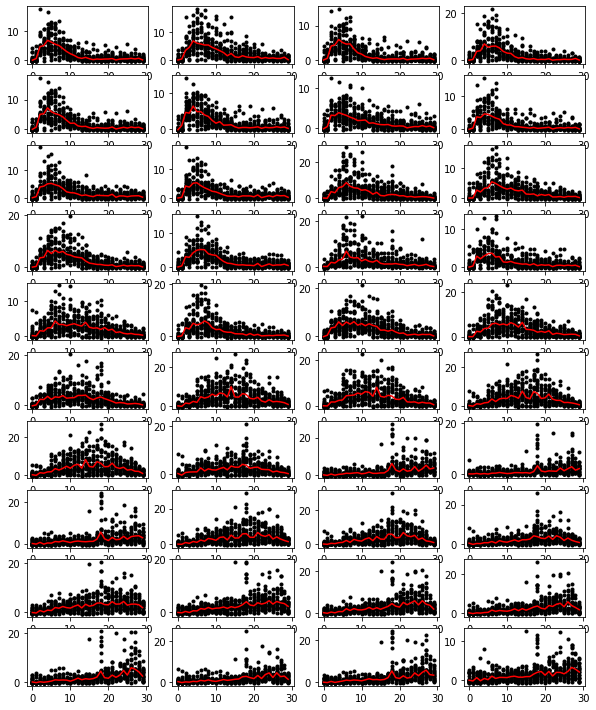

In [13]:
fig, axes = plt.subplots(Yp.shape[0]//4, 4, figsize=(10, 12.5))
for ax_idx, ax in enumerate(axes.ravel()):
    counts = Yp[ax_idx]
    freqs = np.tile(np.arange(n_freq)[:, np.newaxis], (1, Yp.shape[-1]))
    ax.scatter(freqs, counts, marker='.', color='k')
    ax.plot(np.median(freqs, axis=1), np.median(counts, axis=1), color='r')

In [13]:
delta_fs = 2
delta_es = 2
n_boot = 10000

n_pts = 0
for ii in range(n_el - 2):
    for d in range(delta_es):
        n0 = ii
        n1 = ii + d + 1
        minf = max(0, bfs[n0] - delta_fs)
        maxf = min(n_freq - 1, bfs[n1] + delta_fs + 1)
        n_pts += maxf - minf
print(n_pts)
    
ps = np.full((2, 2, n_pts), np.nan)
idx = 0
for ii in range(n_el - 2):
    print(float(idx) / n_pts)
    for d in range(delta_es):
        n0 = ii
        n1 = ii + d + 1
        minf = max(0, bfs[n0] - delta_fs)
        maxf = min(n_freq - 1, bfs[n1] + delta_fs + 1)
        for f in range(minf, maxf):
            x = Yp[[n0, n1]][:, f].T
            y = Yp[[n0, n1]][:, f + 1].T
            val_s, values_s, ps_s = null_models.eval_null_data(x, y, shuffle_data,
                                                               [lfi_data, mv_normal_jeffreys_data], n_boot)
            val_r, values_r, ps_r = null_models.eval_null_data(x, y, random_rotation_data,
                                                               [lfi_data, mv_normal_jeffreys_data], n_boot)
            ps[0, :, idx] = ps_s
            ps[1, :, idx] = ps_r
            idx += 1

336
0.0
0.02976190476190476
0.05952380952380952
0.08928571428571429
0.11904761904761904
0.15178571428571427
0.1875
0.22023809523809523
0.25595238095238093
0.2857142857142857
0.31547619047619047
0.34523809523809523
0.37797619047619047
0.4166666666666667
0.47023809523809523
0.5357142857142857
0.5654761904761905
0.5952380952380952
0.625
0.6666666666666666
0.7202380952380952
0.7589285714285714
0.8065476190476191
0.8511904761904762
0.9107142857142857
0.9404761904761905
0.9702380952380952


In [14]:
np.savez('ps_max', ps=ps)

In [25]:
rng = np.random.RandomState(20190221)

n_pts = 1000
n_boot = 10000

R1s = []
R2s = []
for nn in range(n_boot):
    angle = 2. * np.pi * rng.rand()
    R = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
    R1s.append(R)
    angle = 2. * np.pi * rng.rand()
    R = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
    R2s.append(R)

df = np.full(n_pts, np.nan)
ps = np.full((2, 2, n_pts), np.nan)
idx = 0
for ii in range(n_pts):
    print(float(ii) / n_pts)
    es = rng.permutation(Yp.shape[0])[:2]
    fs = rng.permutation(Yp.shape[1])[:2]
    df[ii] = np.diff(fs)
    x = Yp[es][:, fs[0]].T
    y = Yp[es][:, fs[1]].T
    o_val, values_s, ps_s = null_models.eval_null_data(x, y, shuffle_data,
                                                       [lfi_data, mv_normal_jeffreys_data], n_boot)
    all_vals = np.zeros((2, n_boot))
    for jj in range(n_boot):
        r = R1s[jj]
        mux = x.mean(axis=0, keepdims=True)
        xp = (x - mux).dot(r.T) + mux
        muy = y.mean(axis=0, keepdims=True)
        yp = (y - muy).dot(r.T) + muy
        all_vals[0, jj] = lfi_data(xp, yp)
        r = R2s[jj]
        muy = y.mean(axis=0, keepdims=True)
        yp = (y - muy).dot(r.T) + muy
        all_vals[1, jj] = mv_normal_jeffreys_data(xp, yp)
    all_vals = np.concatenate([all_vals, o_val[:, np.newaxis]], axis=1)
    ps[0, :, ii] = ps_s
    ps[1, :, ii] = (all_vals >= o_val[:, np.newaxis]).mean(axis=1)

np.savez('ps2_max', ps=ps, df=df)

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.011
0.012
0.013
0.014
0.015
0.016
0.017
0.018
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026
0.027
0.028
0.029
0.03
0.031
0.032
0.033
0.034
0.035
0.036
0.037
0.038
0.039
0.04
0.041
0.042
0.043
0.044
0.045
0.046
0.047
0.048
0.049
0.05
0.051
0.052
0.053
0.054
0.055
0.056
0.057
0.058
0.059
0.06
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.071
0.072
0.073
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.086
0.087
0.088
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1
0.101
0.102
0.103
0.104
0.105
0.106
0.107
0.108
0.109
0.11
0.111
0.112
0.113
0.114
0.115
0.116
0.117
0.118
0.119
0.12
0.121
0.122
0.123
0.124
0.125
0.126
0.127
0.128
0.129
0.13
0.131
0.132
0.133
0.134
0.135
0.136
0.137
0.138
0.139
0.14
0.141
0.142
0.143
0.144
0.145
0.146
0.147
0.148
0.149
0.15
0.151
0.152
0.153
0.154
0.155
0.156
0.157
0.158
0.159
0.16
0.161
0.162
0.163
0.164
0.165
0.166
0.167
0.168
0.169

(0.003999600039996, 1)

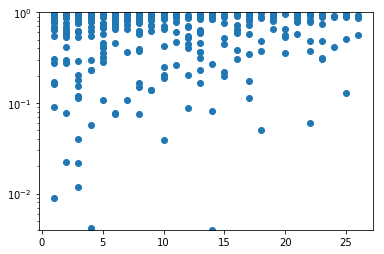

In [24]:
y = ps[1, 0]
plt.scatter(abs(df), y)
plt.yscale('log')
plt.ylim(y.min(), 1)

In [19]:
y.min()

0.0

In [17]:
ps

array([[[1.83000000e-02, 6.50000000e-03, 1.00000000e+00, ...,
         4.56900000e-01, 1.00000000e+00, 9.76000000e-01],
        [1.53600000e-01, 3.03000000e-02, 1.00000000e+00, ...,
         2.00000000e-04, 1.00000000e+00, 4.68000000e-02]],

       [[8.19718028e-01, 9.42305769e-01, 9.87301270e-01, ...,
         9.59804020e-01, 9.27807219e-01, 7.67823218e-01],
        [7.58724128e-01, 9.68303170e-01, 9.84201580e-01, ...,
         7.51324868e-01, 9.97000300e-01, 8.81911809e-01]]])

Bbox(x0=0.125, y0=0.125, x1=0.47727272727272724, y1=0.88)
sig shuffle:  0.33707865168539325
sig rotate:  0.07865168539325842
only sig shuffle:  0.2612359550561798
only sig rotate:  0.0028089887640449437
sig both:  0.07584269662921349

sig shuffle:  0.0
sig rotate:  0.0
only sig shuffle:  0.0
only sig rotate:  0.0
sig both:  0.0



/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher

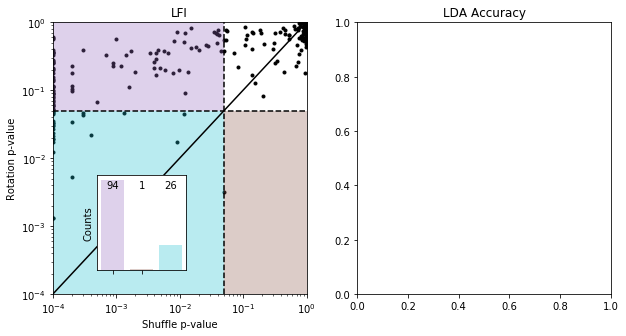

In [21]:
reload(plot)
faxes = plt.subplots(1, 2, figsize=(10, 5))
f, (ax0, ax1) = faxes
plot.plot_pvalue_comparison(ps[0, 0].ravel(), ps[1, 0].ravel(),
                           labels=['Shuffle p-value', 'Rotation p-value'], faxes=(f, ax0))
#plot.plot_pvalue_comparison(ps[0, 1].ravel(), ps[1, 1].ravel(),
#                       labels=['Shuffle p-value', 'Rotation p-value'], faxes=(f, ax1))
ax0.set_title('LFI')
ax1.set_title('LDA Accuracy')
#plt.savefig('/home/jesse/Downloads/maxd.pdf')

for ii in range(2):
    print('sig shuffle: ', (ps[0, ii] <= .05).sum() / ps[0, ii].size)
    print('sig rotate: ', (ps[1, ii] <= .05).sum() / ps[1, ii].size)
    print('only sig shuffle: ', (np.logical_and(ps[0, ii] <= .05, ps[1, ii] > .05)).sum() / ps[0, ii].size)
    print('only sig rotate: ', (np.logical_and(ps[1, ii] <= .05, ps[0, ii] > .05)).sum() / ps[0, ii].size)
    print('sig both: ', (np.logical_and(ps[0, ii] <= .05, ps[1, ii] <= .05)).sum() / ps[0, ii].size)
    print()